In [ ]:
from plancraft.environments.env_real import RealPlancraft

env = RealPlancraft(
    inventory=[{"type": "beetroot_soup", "quantity": 1, "slot": 45}],
    symbolic_action_space=True,
    symbolic_observation_space=True,
    resolution=[512, 512],
    crop=True,
)
data = []

In [ ]:
import torch
from train_fast_rcnn import M1, M2, prepare_m2_batch, sample_environment

# m1_path = "m1.pth"
# m2_path = "m2.pth"
# M1_model = M1(weights_path = m1_path)
# M1_model = M1_model.cuda()
M2_model = M2()
M2_model = M2_model.cuda()
print("Loaded model")

N = 1000
lr = 0.001
batch_size = 4
save_every = 100
count = 0
# m1_optimizer = torch.optim.AdamW(M1_model.parameters(), lr=lr)
m2_optimizer = torch.optim.AdamW(M2_model.parameters(), lr=lr)

In [ ]:
for images, targets, raw_images, inv in sample_environment(N=N, batch_size=batch_size):
        break

In [ ]:
from PIL import Image

# train M2
for img, inventory in zip(raw_images, inv):
    i = Image.fromarray(img.copy())
    m2_batch = prepare_m2_batch(i, inventory)
    m2_batch["bbox_tensors"] = torch.stack(m2_batch["bbox_tensors"]).cuda()
    m2_batch["item_quantity"] = m2_batch["item_quantity"].unsqueeze(1).cuda()
    m2_batch["item_locations"] = m2_batch["item_locations"].cuda()
    m2_batch["item_types"] = m2_batch["item_types"].cuda()
    break
    # M2_model.train()
    # M2_model(m2_batch)
    # losses = sum(loss for loss in loss_dict.values())
    # m2_optimizer.zero_grad()
    # losses.backward()
    # m2_optimizer.step()

# N = len(m2_batch["item_types"])
# encoded_img = M2_model.img_encoder(m2_batch["bbox_tensors"]).reshape(N, -1)

# M2_model.quantity_encoder(m2_batch["item_quantity"].unsqueeze(1))

# m2_batch["item_quantity"].shape
# 
# m2_batch["item_quantity"]


In [ ]:
import glob
from PIL import Image
import numpy as np


image_paths = glob.glob("data/oracle/train/imgs/*.png")
# load images
image_arrays = [Image.open(p) for p in image_paths]
# to tensor
image_tensors = [np.array(i)/255 for i in image_arrays]

# stack
image_tensors = np.stack(image_tensors)

In [ ]:
image_tensors_mean = image_tensors.mean(axis=(0, 1, 2))
image_tensors_std = image_tensors.std(axis=(0, 1, 2))
print(image_tensors_mean, image_tensors_std)

In [ ]:
from minerl.herobraine.hero.mc import ALL_ITEMS

In [ ]:
from typing import Dict, List
import torch.nn as nn
from torchvision.models.detection.roi_heads import (
    RoIHeads,
    fastrcnn_loss,
    maskrcnn_loss,
    maskrcnn_inference,
    keypointrcnn_loss,
    keypointrcnn_inference,
)


class OverrideRoIHeads(RoIHeads):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.quantity_predictor = nn.Sequential(nn.Linear(1024, 1), nn.Sigmoid())

    def forward(
        self,
        features,  # type: Dict[str, Tensor]
        proposals,  # type: List[Tensor]
        image_shapes,  # type: List[Tuple[int, int]]
        targets=None,  # type: Optional[List[Dict[str, Tensor]]]
    ):
        """
        Args:
            features (List[Tensor])
            proposals (List[Tensor[N, 4]])
            image_shapes (List[Tuple[H, W]])
            targets (List[Dict])
        """
        if targets is not None:
            for t in targets:
                # TODO: https://github.com/pytorch/pytorch/issues/26731
                floating_point_types = (torch.float, torch.double, torch.half)
                if not t["boxes"].dtype in floating_point_types:
                    raise TypeError(
                        f"target boxes must of float type, instead got {t['boxes'].dtype}"
                    )
                if not t["labels"].dtype == torch.int64:
                    raise TypeError(
                        f"target labels must of int64 type, instead got {t['labels'].dtype}"
                    )
                if self.has_keypoint():
                    if not t["keypoints"].dtype == torch.float32:
                        raise TypeError(
                            f"target keypoints must of float type, instead got {t['keypoints'].dtype}"
                        )

        if self.training:
            proposals, matched_idxs, labels, regression_targets = (
                self.select_training_samples(proposals, targets)
            )
        else:
            labels = None
            regression_targets = None
            matched_idxs = None

        box_features = self.box_roi_pool(features, proposals, image_shapes)
        box_features = self.box_head(box_features)
        class_logits, box_regression = self.box_predictor(box_features)
        quantity_logits = self.quantity_predictor(box_features)

        result: List[Dict[str, torch.Tensor]] = []
        losses = {}
        if self.training:
            if labels is None:
                raise ValueError("labels cannot be None")
            if regression_targets is None:
                raise ValueError("regression_targets cannot be None")
            loss_classifier, loss_box_reg = fastrcnn_loss(
                class_logits, box_regression, labels, regression_targets
            )


            losses = {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}
        else:
            boxes, scores, labels = self.postprocess_detections(
                class_logits, box_regression, proposals, image_shapes
            )
            num_images = len(boxes)
            for i in range(num_images):
                result.append(
                    {
                        "boxes": boxes[i],
                        "labels": labels[i],
                        "scores": scores[i],
                    }
                )

        if self.has_mask():
            mask_proposals = [p["boxes"] for p in result]
            if self.training:
                if matched_idxs is None:
                    raise ValueError("if in training, matched_idxs should not be None")

                # during training, only focus on positive boxes
                num_images = len(proposals)
                mask_proposals = []
                pos_matched_idxs = []
                for img_id in range(num_images):
                    pos = torch.where(labels[img_id] > 0)[0]
                    mask_proposals.append(proposals[img_id][pos])
                    pos_matched_idxs.append(matched_idxs[img_id][pos])
            else:
                pos_matched_idxs = None

            if self.mask_roi_pool is not None:
                mask_features = self.mask_roi_pool(features, mask_proposals, image_shapes)
                mask_features = self.mask_head(mask_features)
                mask_logits = self.mask_predictor(mask_features)
            else:
                raise Exception("Expected mask_roi_pool to be not None")

            loss_mask = {}
            if self.training:
                if targets is None or pos_matched_idxs is None or mask_logits is None:
                    raise ValueError(
                        "targets, pos_matched_idxs, mask_logits cannot be None when training"
                    )

                gt_masks = [t["masks"] for t in targets]
                gt_labels = [t["labels"] for t in targets]
                rcnn_loss_mask = maskrcnn_loss(
                    mask_logits, mask_proposals, gt_masks, gt_labels, pos_matched_idxs
                )
                loss_mask = {"loss_mask": rcnn_loss_mask}
            else:
                labels = [r["labels"] for r in result]
                masks_probs = maskrcnn_inference(mask_logits, labels)
                for mask_prob, r in zip(masks_probs, result):
                    r["masks"] = mask_prob

            losses.update(loss_mask)

        # keep none checks in if conditional so torchscript will conditionally
        # compile each branch
        if (
            self.keypoint_roi_pool is not None
            and self.keypoint_head is not None
            and self.keypoint_predictor is not None
        ):
            keypoint_proposals = [p["boxes"] for p in result]
            if self.training:
                # during training, only focus on positive boxes
                num_images = len(proposals)
                keypoint_proposals = []
                pos_matched_idxs = []
                if matched_idxs is None:
                    raise ValueError("if in trainning, matched_idxs should not be None")

                for img_id in range(num_images):
                    pos = torch.where(labels[img_id] > 0)[0]
                    keypoint_proposals.append(proposals[img_id][pos])
                    pos_matched_idxs.append(matched_idxs[img_id][pos])
            else:
                pos_matched_idxs = None

            keypoint_features = self.keypoint_roi_pool(
                features, keypoint_proposals, image_shapes
            )
            keypoint_features = self.keypoint_head(keypoint_features)
            keypoint_logits = self.keypoint_predictor(keypoint_features)

            loss_keypoint = {}
            if self.training:
                if targets is None or pos_matched_idxs is None:
                    raise ValueError(
                        "both targets and pos_matched_idxs should not be None when in training mode"
                    )

                gt_keypoints = [t["keypoints"] for t in targets]
                rcnn_loss_keypoint = keypointrcnn_loss(
                    keypoint_logits, keypoint_proposals, gt_keypoints, pos_matched_idxs
                )
                loss_keypoint = {"loss_keypoint": rcnn_loss_keypoint}
            else:
                if keypoint_logits is None or keypoint_proposals is None:
                    raise ValueError(
                        "both keypoint_logits and keypoint_proposals should not be None when not in training mode"
                    )

                keypoints_probs, kp_scores = keypointrcnn_inference(
                    keypoint_logits, keypoint_proposals
                )
                for keypoint_prob, kps, r in zip(keypoints_probs, kp_scores, result):
                    r["keypoints"] = keypoint_prob
                    r["keypoints_scores"] = kps
            losses.update(loss_keypoint)

        return result, losses
    


from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2

model = fasterrcnn_resnet50_fpn_v2(pretrained=True)
model.roi_heads = OverrideRoIHeads(model.roi_heads.box_roi_pool, model.roi_heads.box_head, model.roi_heads.box_predictor, model.roi_heads)



In [ ]:
import torch
import torch.nn as nn   
import torch.nn.functional as F
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn_v2
from minerl.herobraine.hero.mc import ALL_ITEMS

class M2(nn.Module):
    def __init__(self):
        super(M2, self).__init__()
        self.box_feats = None
        self.proposals = None
        self.image_shapes = None

        self.model = fasterrcnn_resnet50_fpn_v2(
            pretrained=False,
            image_mean=[0.63, 0.63, 0.63],
            image_std=[0.21, 0.21, 0.21],
            min_size=64,
            max_size=64,
            num_classes=len(ALL_ITEMS),
        )

        # need to save the intermediate features
        # self.model.roi_heads.box_predictor.cls_score.register_pre_forward_hook(
        self.model.roi_heads.box_roi_pool.register_forward_pre_hook(
            self.save_prop_img_shape
        )
        self.model.roi_heads.box_predictor.register_forward_hook(self.save_box_feats)
        # self.model.roi_heads.box_predictor.bbox_pred.register_forward_pre_hook(
        #     self.save_feats
        # )
        self.quantity_prediction = nn.Sequential(nn.Linear(1024, 1), nn.Sigmoid())
        
    def save_prop_img_shape(self, _module, input):
        # Save the input features to be used later
        self.proposals = input[1]
        print("self.proposals", self.proposals[0].shape)
        self.image_shapes = input[2]
        # print("self.proposals", self.proposals.shape)
        # print("self.image_shapes", self.image_shapes)
    
    def save_box_feats(self, _module, input, output):
        self.box_feats = input[0]
        self.class_logits = output[0]

    def forward(self, x, targets=None, quantity_targets=None):
        if self.training:
            # assert targets is not None and quantity_targets is not None
            print(self.box_feats)
            loss_dict = self.model(x, targets)
            print("box_feats", self.box_feats.shape)
            print("class_logits", self.class_logits.shape)
            print("targets", targets["labels"])


            # custom_classification_loss = F.cross_entropy(
            #     self.class_logits, targets["labels"]
            # )
            # print(custom_classification_loss)

            # loss_classifier 
            # Compute the loss for the quantity classifier
            # predicted_quantities = self.quantity_prediction(self.feats)
            # loss_dict["quantity_loss"] = F.mse_loss(predicted_quantities, quantity_targets)
            return loss_dict
        else:
            print(self.box_feats)
            preds = self.model(x)
            print(self.box_feats.shape)
            # preds["predicted_quantities"] = self.quantity_prediction(
            #     self.feats
            # )
            return preds

m = M2()
m.train()
m.cuda()

fake_inputs = [torch.rand(3, 64, 64).cuda(), torch.rand(3, 64, 64).cuda()]
fake_targets = [
    {
        "boxes": torch.tensor([[10, 10, 20, 20], [30, 30, 40, 40]]).cuda(),
        "labels": torch.tensor([1, 2]).cuda(),
    },
    {
        "boxes": torch.tensor([[10, 10, 20, 20], [30, 30, 40, 40]]).cuda(),
        "labels": torch.tensor([1, 2]).cuda(),
    },
]

m(fake_inputs, targets=fake_targets)

In [ ]:
m.model.roi_heads

In [ ]:
from torchvision.models.detection.faster_rcnn import (
    FastRCNNPredictor,
    FasterRCNN,
    _default_anchorgen,
    RPNHead,
    FastRCNNConvFCHead,
)
from torchvision.models.resnet import resnet50
import torch.nn as nn


class DualFastRCNNPredictor(nn.Module):
    def __init__(self, in_channels=1024):
        super(DualFastRCNNPredictor, self).__init__()
        self.quantity_predictor = FastRCNNPredictor(in_channels, 65)
        self.label_predictor = FastRCNNPredictor(in_channels, 900)

    def forward(self, x):
        return (self.quantity_predictor(x), self.label_predictor(x))

def fasterrcnn_resnet50_fpn_v2(
    **kwargs
) -> FasterRCNN:
    """
    Constructs an improved Faster R-CNN model with a ResNet-50-FPN backbone from `Benchmarking Detection
    Transfer Learning with Vision Transformers <https://arxiv.org/abs/2111.11429>`__ paper.
    """
    backbone = resnet50(weights=None, progress=False)
    rpn_anchor_generator = _default_anchorgen()
    rpn_head = RPNHead(
        backbone.out_channels,
        rpn_anchor_generator.num_anchors_per_location()[0],
        conv_depth=2,
    )
    box_head = FastRCNNConvFCHead(
        (backbone.out_channels, 7, 7),
        [256, 256, 256, 256],
        [1024],
        norm_layer=nn.BatchNorm2d,
    )
    dual_head = DualFastRCNNPredictor()
    model = FasterRCNN(
        backbone,
        num_classes=None,
        rpn_anchor_generator=rpn_anchor_generator,
        rpn_head=rpn_head,
        box_head=box_head,
        box_predictor=dual_head,
        **kwargs,
    )
    return model



# # mean=[0.508, 0.492, 0.476], std=[0.241, 0.244, 0.255]
# m = FasterRCNN(
#     num_classes=None,
#     pretrained=False,
#     
#     box_predictor=dual_head,
# )
# m.transform
m = fasterrcnn_resnet50_fpn_v2()

In [ ]:
# from train_fast_rcnn import M2
import glob
import torch
import torch.nn as nn
import torchvision.transforms.v2 as v2
from torchvision.models import mobilenet_v3_small
from torch.utils.data import DataLoader, Dataset
from minerl.herobraine.hero.mc import ALL_ITEMS
import wandb
from PIL import Image

wandb.require("core")

# model = M2()
# model = model.cuda()

img_encoder = mobilenet_v3_small(
    pretrained=True,
    image_mean=[0.508, 0.492, 0.476],
    image_std=[0.241, 0.244, 0.255],
    min_size=64,
    max_size=64,
)
img_encoder.classifier = nn.Linear(576, len(ALL_ITEMS))
img_encoder.cuda()

# images are in data/bboxes/*.png
class BboxDataset(Dataset):
    def __init__(self, img_dir):
        self.img_dir = img_dir
        self.transform = v2.Compose(
            [
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                # v2.Normalize(mean=[0.508, 0.492, 0.476], std=[0.241, 0.244, 0.255]),
            ]
        )
        self.paths = glob.glob(f"{img_dir}/*.png")
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        target = "_".join(img_path.split("/")[-1].split(".")[0].split("_")[1:])
        return img, ALL_ITEMS.index(target)


dataset = BboxDataset("data/bboxes")
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)
m2_optimizer = torch.optim.AdamW(img_encoder.parameters(), lr=0.001)

# wandb.init(project="plancraft-img-encoder", entity="itl")  # , mode="disabled")

i = 0
for images, labels in dataloader:
    # for i in range(1000):
    encoded_image = img_encoder(images.cuda())
    loss = nn.CrossEntropyLoss()(nn.Softmax(dim=1)(encoded_image), labels.cuda())
    # wandb.log({"loss": loss})
    if i%100 == 0:
        print(loss)
        # torch.save(img_encoder.state_dict(), "mobilenet.pth")

    m2_optimizer.zero_grad()
    loss.backward()
    m2_optimizer.step()
        # model(batch.cuda())
    i+=1



In [ ]:
images.shape

In [ ]:
preds = img_encoder(images.cuda()).softmax(dim=1).argmax(dim=1)
(preds == labels.cuda()).sum() / len(labels)
# for pred, label in zip(preds, labels):
#     print(ALL_ITEMS[pred], ALL_ITEMS[label])

In [ ]:
img_encoder.classifier = nn.Identity()
torch.save(img_encoder.state_dict(), "mobilenet.pth")

In [ ]:
# encoded_image[0].softmax()
wandb.finish()


In [ ]:
len(glob.glob(f"data/bboxes/*.png"))

In [ ]:
from PIL import Image
from glob import glob
import numpy as np
from tqdm import tqdm

image_paths = glob("data/bboxes/*.png")
img_arrs = []
for image_path in tqdm(image_paths):
    img = Image.open(image_path)
    img_arr = np.array(img)
    img_arrs.append(img_arr)

# get mean and std
img_arrs = np.array(img_arrs)

In [ ]:
img_arrs = img_arrs / 255
# (72568, 64, 64, 3)

In [ ]:
mean = np.mean(img_arrs, axis=(0, 1, 2))

In [ ]:
std = np.std(img_arrs, axis=(0, 1, 2))

In [ ]:
mean, std

In [ ]:
from PIL import Image, ImageDraw
from torchvision import transforms
import torch
from train_fast_rcnn import slot_to_bbox, sample_starting_inv

starting_inv = sample_starting_inv()
env.fast_reset(new_inventory=starting_inv)
obs, _, _, _ = env.step(env.action_space.no_op())

img = Image.fromarray(obs["pov"])
for item in obs["inventory"]:
    draw = ImageDraw.Draw(img)
    bbox = slot_to_bbox(item["index"])
    draw.rectangle(bbox, outline="red")

img_tensor = transforms.ToTensor()(obs["pov"].copy()).cuda()
# with torch.no_grad():
#     predictions = model(img_tensor.unsqueeze(0)) 

# for box_idx in range(len(predictions[0]["boxes"])):
#     if predictions[0]["scores"][box_idx] < 0.3:
#         continue
#     box = predictions[0]["boxes"][box_idx]
#     label = predictions[0]["labels"][box_idx]
#     draw = ImageDraw.Draw(img)
#     draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline="blue")
#     # add text label in middle of box
#     draw.text(
#         (box[0].item() + (box[2].item() - box[0].item()) / 2, box[1].item() + (box[3].item() - box[1].item()) / 2),
#         str(label.item()),
#         fill="green",
#     )
# # show
img.show()

In [ ]:
from PIL import Image, ImageDraw
from train_fast_rcnn import slot_to_bbox, sample_starting_inv

from torchvision import transforms
from PIL import Image, ImageDraw


img = Image.fromarray(obs["pov"])
for item in obs["inventory"]:
    draw = ImageDraw.Draw(img)
    bbox = slot_to_bbox(item["index"])
    draw.rectangle(bbox, outline="red")

# img_tensor = transforms.ToTensor()(obs["pov"].copy()).cuda()
# with torch.no_grad():
#     predictions = model(img_tensor.unsqueeze(0)) 

# print(predictions)

# for box_idx in range(len(predictions[0]["boxes"])):
#     if predictions[0]["scores"][box_idx] < 0.3:
#         continue
#     box = predictions[0]["boxes"][box_idx]
#     label = predictions[0]["labels"][box_idx]
#     draw = ImageDraw.Draw(img)
#     draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline="blue")
#     # add text label in middle of box
#     draw.text(
#         (box[0].item() + (box[2].item() - box[0].item()) / 2, box[1].item() + (box[3].item() - box[1].item()) / 2),
#         str(label.item()+1),
#         fill="red",
#     )

img.show()

In [ ]:
obs["inventory"]

In [ ]:
from torchvision import transforms
from PIL import Image, ImageDraw

model.eval()

idx = 0
img_tensor = transforms.ToTensor()(data[idx]["pov"].copy()).cuda()

with torch.no_grad():
    predictions = model(img_tensor.unsqueeze(0))  

img = Image.fromarray(data[idx]["pov"])
for item in data[-1]["inventory"]:
    draw = ImageDraw.Draw(img)
    draw.rectangle(item["bbox"], outline="red")

for box_idx in range(len(predictions[0]["boxes"])):
    if predictions[0]["scores"][box_idx] < 0.5:
        continue
    box = predictions[0]["boxes"][box_idx]
    label = predictions[0]["labels"][box_idx]
    draw = ImageDraw.Draw(img)
    draw.rectangle([box[0].item(), box[1].item(), box[2].item(), box[3].item()], outline="blue")

    # add text label in middle of box
    draw.text(
        (box[0].item() + (box[2].item() - box[0].item()) / 2, box[1].item() + (box[3].item() - box[1].item()) / 2),
        str(label.item()+1),
        fill="red",
    )

img.show()

In [ ]:
def tmp():
    n = 0
    while n < 10:
        if n == 5:
            return
        yield n
        n += 1

for i in tmp():
    print(i) 

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class InventoryDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.transform(self.data[idx]["pov"].copy())
        target = {
            "labels": [],
            "boxes": []
        }

        for i in self.data[idx]["inventory"]:
            target["labels"].append(i["quantity"])
            target["boxes"].append(i["bbox"])
        
        target["labels"] = torch.tensor(target["labels"], dtype=torch.int64)-1
        target["boxes"] = torch.tensor(target["boxes"], dtype=torch.int64)
        
        return img, target
    
# N = len(data)
train_dataset = InventoryDataset(data)
# val_dataset = InventoryDataset(data[int(N*0.9):])

In [ ]:
import wandb
wandb.require("core")

In [ ]:
import wandb
from torch.utils.data import DataLoader

num_epochs = 10
batch_size = 2
lr = 0.005

def collate_fn(batch):
    image_stack = []
    target_stack = []
    for img, target in batch:
        image_stack.append(img)
        target_stack.append(target)
    return torch.stack(image_stack), target_stack


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, collate_fn=collate_fn)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, collate_fn=collate_fn)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

wandb.init(project="plancraft-img-encoder", entity="itl")

batch_num = 1
for epoch in range(num_epochs):
    model.train()
    for imgs, labels in train_loader:
        imgs = imgs.cuda()
        for i in range(len(labels)):
            labels[i]["boxes"] = labels[i]["boxes"].cuda()
            labels[i]["labels"] = labels[i]["labels"].cuda()
        loss_dict = model(imgs, labels)
        wandb.log(loss_dict)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        batch_num += 1
        if batch_num % 100 == 0:
            print(f"Epoch {epoch}, Batch {batch_num}, Loss: {losses}")

    # model.eval()
    # with torch.no_grad():
    #     for imgs, labels in val_loader:
    #         imgs = imgs.cuda()
    #         for i in range(len(labels)):
    #             labels[i]["boxes"] = labels[i]["boxes"].cuda()
    #             labels[i]["labels"] = labels[i]["labels"].cuda()

    #         loss_dict = model(imgs, labels)

    #         val_loss_dict = {}
    #         for k, v in loss_dict.items():
    #             val_loss_dict[f"val_{k}"] = v.item()
    #         wandb.log(val_loss_dict)

    #         losses = sum(loss for loss in loss_dict.values())
    # print(f"Epoch {epoch}, Loss: {losses}")

# wandb.finish()

In [ ]:
class GenerativeDataset:
    def __iter__(self):
        return self
    def __next__(self):
        return 1

a = GenerativeDataset()

c = 0
for i in a:
    print(i)
    c += 1
    if c == 10:
        break


In [ ]:
losses = sum(loss for loss in loss_dict.values())

In [ ]:
# data[0]["pov"]
torch.tensor([1])

In [ ]:
help(model.forward)

In [ ]:
import glob
import numpy as np
from PIL import Image, ImageSequence

observed_data = []

for f in glob.glob("/plancraft/outputs/oracle_real/train/0/*.json"):
    with open(f, "r") as file:
        inventories = json.load(file)["model_trace"]["inventory_history"]
    gif_path = str(f).replace(".json", ".gif")
    # load gif as list of images
    gif = Image.open(gif_path)
    frames = [frame.copy() for frame in ImageSequence.Iterator(gif)]
    if len(frames) != len(inventories):
        print(f)
    else:
        for frame, inv in zip(frames, inventories):
            clean_inv = []
            for item in inv:
                if item["quantity"] > 0:
                    clean_inv.append(
                        {
                            "type": item["type"],
                            "slot": item["index"],
                            "quantity": item["quantity"],
                            "bbox": slot_to_bbox(item["index"]),
                        }
                    )
            observed_data.append(
                {"inventory": clean_inv, "pov": np.array(frame.convert("RGB"))}
            )
    # assert len(frames) == len(inv), (len(frames), len(inv))

In [ ]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms


class InventoryDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize((224, 224)),  # Resize images to 224x224
            ]
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        pov = item["pov"]
        pov = self.transform(pov)

        inventory = item["inventory"]
        types = [i["type"] for i in inventory]
        slots = [i["slot"] for i in inventory]
        quantities = [i["quantity"] for i in inventory]
        bboxes = [i["bbox"] for i in inventory]

        return pov, types, slots, quantities, bboxes


def collate_fn(batch):
    return tuple(zip(*batch))

dataset = InventoryDataset(observed_data)
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)
batch = next(iter(train_loader))

In [ ]:
import torch.nn as nn
import torchvision.models as models

class InventoryModel(nn.Module):
    def __init__(self, num_types, num_slots):
        super(InventoryModel, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove the classification layer

        # Bounding box head
        self.bbox_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 4),  # 4 coordinates for the bounding box
        )

        # Slot index prediction head
        self.slot_head = nn.Sequential(
            nn.Linear(512, 128), nn.ReLU(), nn.Linear(128, num_slots), nn.Softmax(dim=1)
        )

        # Quantity prediction head
        self.quantity_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Softmax(dim=1), 
        )

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad) // 1000000

    def forward(self, x):
        features = self.backbone(x)
        bbox = self.bbox_head(features)
        # types = self.type_head(features)
        slots = self.slot_head(features)
        quantity = self.quantity_head(features)
        return bbox, slots, quantity


# Example usage
model = InventoryModel(num_types=100, num_slots=45)  # Replace with actual numbers
model = model.cuda()
# Count number of parameters
print(f"Model has {model.count_parameters()}M parameters")

# Get oracle O,A Dialogues

In [ ]:
import json
import glob
import numpy as np
from PIL import Image, ImageSequence

oracle_trajectories_train = []
oracle_results = {
    "/plancraft/outputs/oracle_real/train/0/*.json": [],
    "/plancraft/outputs/oracle_real/val/0/*.json": [],
}
for path in oracle_results.keys():
    for f in glob.glob(path):
        with open(f, "r") as file:
            traj = json.load(file)

        images = []
        gif_path = str(f).replace(".json", ".gif")
        gif = Image.open(gif_path)
        for frame in ImageSequence.Iterator(gif):
            images.append(np.array(frame.convert("RGB")))
        traj["model_trace"]["images"] = images

        if (
            len(traj["model_trace"]["images"])
            == len(traj["model_trace"]["inventory_history"])
            == len(traj["model_trace"]["action_history"])
        ):
            oracle_results[path].append(traj)
        else:
            print(f)

In [ ]:
import os
from plancraft.models.react_prompts import REACT_SYSTEM_PROMPT
from collections import defaultdict


def convert_obs_to_text(objective: str, inventory: list[dict]):
    return f"TASK: {objective}\ninventory={json.dumps(inventory)}"


def convert_action_to_text(action: dict):
    # {'action_type': 'move', 'slot_from': 17, 'slot_to': 1, 'quantity': 1}
    return f"act: {action['action_type']} from slot {action['slot_from']} to slot {action['slot_to']} with quantity {action['quantity']}"


# convert action and inventory to dialogue history
def convert_trajectory_to_base_dialogue(traj: dict):
    dialogue = [{"role": "system", "content": REACT_SYSTEM_PROMPT}]
    objective = traj["model_trace"]["objective"]
    for _, action, inventory in zip(
        traj["model_trace"]["images"],
        traj["model_trace"]["action_history"],
        traj["model_trace"]["inventory_history"],
    ):
        dialogue.append(
            {
                "role": "user",
                "content": convert_obs_to_text(objective, inventory),
            }
        )
        dialogue.append(
            {
                "role": "assistant",
                "content": convert_action_to_text(action),
            }
        )
    example = {
        "messages": dialogue,
        "example_id": traj["example_id"],
    }
    return example


# convert action and inventory to dialogue history
def convert_trajectory_to_image_dialogue(traj: dict):
    dialogue = [
        {"role": "system", "content": [{"type": "text", "text": REACT_SYSTEM_PROMPT}]}
    ]
    objective = traj["model_trace"]["objective"]
    images = []
    for image, action, inventory in zip(
        traj["model_trace"]["images"],
        traj["model_trace"]["action_history"],
        traj["model_trace"]["inventory_history"],
    ):
        dialogue.append(
            {
                "role": "user",
                "content": [{"type": "image"}, {"type": "text", "text": objective}],
            }
        )
        dialogue.append(
            {
                "role": "assistant",
                "content": [{"type": "text", "text": convert_action_to_text(action)}],
            }
        )
        images.append(image)
    example = {
        "messages": dialogue,
        "example_id": traj["example_id"],
    }
    return example, images


text_data = defaultdict(list)
mm_data = defaultdict(list)
for path, trajs in oracle_results.items():
    split = path.split("/")[-3]
    for traj in trajs:
        text_example = convert_trajectory_to_base_dialogue(traj)
        text_data[split].append(text_example)
        mm_example, example_imgs = convert_trajectory_to_image_dialogue(traj)
        mm_data[split].append(mm_example)
        # save imgs as png in format "data/oracle/{split}/{example_id}_{step}.gif"
        os.makedirs(f"data/oracle/{split}", exist_ok=True)
        for i, img in enumerate(example_imgs):
            Image.fromarray(img).save(
                f"data/oracle/{split}/{traj['example_id']}_{i}.png"
            )

    # save as jsonl file
    with open(f"data/oracle/{split}.jsonl", "w") as f:
        for example in text_data[split]:
            f.write(json.dumps(example) + "\n")

    with open(f"data/oracle/{split}.mm.jsonl", "w") as f:
        for example in mm_data[split]:
            f.write(json.dumps(example) + "\n")

# Train image classifier with Huggingface

In [1]:
from train_fast_rcnn import sample_environment


for batch in sample_environment(batch_size=32, N=100):
    break

/usr/local/lib/python3.10/dist-packages/wandb/analytics/sentry.py:90: SentryHubDeprecationWarning: `sentry_sdk.Hub` is deprecated and will be removed in a future major release. Please consult our 1.x to 2.x migration guide for details on how to migrate `Hub` usage to the new API: https://docs.sentry.io/platforms/python/migration/1.x-to-2.x
  self.hub = sentry_sdk.Hub(client)
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn
/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'minerl.utils.process_watcher' found in sys.modules after import of package 'minerl.utils', but prior to execution of 'minerl.utils.process_watcher'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))


Env loaded


In [2]:
images, targets, raw_images, inv = batch


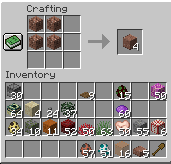

In [6]:
from PIL import Image
import numpy as np

img = Image.fromarray((images[0].cpu().numpy()*255).astype(np.uint8).transpose(1, 2, 0))
img.show()

In [7]:
import torch
from transformers import AutoImageProcessor, AutoModelForObjectDetection

device = "cuda" if torch.cuda.is_available() else "cpu"
model_repo = "qubvel-hf/detr_finetuned_cppe5"

processor = AutoImageProcessor.from_pretrained(model_repo)
model = AutoModelForObjectDetection.from_pretrained(model_repo)

model = model.to(device)

In [11]:
coco_format = []
for i in range(len(targets)):
    annotations = []
    for j in range(len(targets[i]["boxes"])):
        box = targets[i]["boxes"][j].tolist()  # Convert box tensor to list
        area = box[2] * box[3]  # Calculate area (width * height)

        annotation = {
            "bbox": box,  # Bounding box in [x, y, width, height]
            "category_id": targets[i]["labels"][
                j
            ].item(),  # Class label as integer
            "area": area,  # Area of the bounding box
            "iscrowd": 0,  # Default iscrowd to 0 unless specified
        }
        annotations.append(annotation)

    coco_format.append(
        {
            "image_id": i,  # Image ID
            "annotations": annotations,  # List of annotations for the current image
        }
    )

In [24]:
# Now pass the correctly formatted COCO annotations to the processor
inputs= processor(
    images=images,
    annotations=coco_format,
    return_tensors="pt",
    do_rescale=False,
)

# cast to device
# inputs = {name: tensor.to(device) for name, tensor in inputs.items()}
# inputs = [tensor.to(device) for tensor in inputs]
inputs["pixel_values"] = inputs["pixel_values"].to(device)

for i in range(len(inputs["labels"])):
    for k in inputs["labels"][i].keys():
        inputs["labels"][i][k] = inputs["labels"][i][k].to(device)    
    
#     inputs["annotations"][i]["iscrowd"] = inputs["annotations"][i]["iscrowd"].to(device)
#     inputs["annotations"][i]["area"] = inputs["annotations"][i]["area"].to(device)
#     inputs["annotations"][i]["bbox"] = inputs["annotations"][i]["bbox"].to(device)
#     inputs["annotations"][i]["category_id"] = inputs["annotations"][i]["category_id"].to(device)





In [25]:

outputs = model(**inputs) 
                # labels=ta
                # rgets)# target_sizes = torch.tensor([[image.size[1], image.size[0]]])


../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [134,0,0], thread: [96,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [134,0,0], thread: [97,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [134,0,0], thread: [98,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [134,0,0], thread: [99,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [134,0,0], thread: [100,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [134,0,0], thread: [101,0,0] Assertio

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [36]:
targets["labels"]


TypeError: list indices must be integers or slices, not str

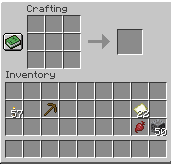

In [6]:
from PIL import Image

image = Image.open("/plancraft/data/oracle/train/imgs/TRAIN0001_0.png")
image.show()



In [28]:
labels = torch.tensor([1, 2, 3, 4, 5])

In [29]:
# with torch.no_grad():
model.train()
inputs = processor(images=[image], return_tensors="pt", labels=labels)
outputs = model(**inputs.to(device))
target_sizes = torch.tensor([[image.size[1], image.size[0]]])

Unused or unrecognized kwargs: labels.


In [27]:
inputs


{'pixel_values': tensor([[[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  1.2728,  ...,  1.2728,  1.2728,  1.2728],
          ...,
          [ 2.2489,  1.2728,  1.2728,  ...,  1.2728,  1.2728, -0.6623],
          [ 1.2728, -0.6623, -0.6623,  ..., -0.6623, -0.6623, -0.6623],
          [-2.1179, -0.6623, -0.6623,  ..., -0.6623, -0.6623, -0.6623]],

         [[ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  1.4307,  ...,  1.4307,  1.4307,  1.4307],
          ...,
          [ 2.4286,  1.4307,  1.4307,  ...,  1.4307,  1.4307, -0.5476],
          [ 1.4307, -0.5476, -0.5476,  ..., -0.5476, -0.5476, -0.5476],
          [-2.0357, -0.5476, -0.5476,  ..., -0.5476, -0.5476, -0.5476]],

         [[ 2.6400,  2.6400,  2.6400,  ...,  2.6400,  2.6400,  2.6400],
          [ 2

In [13]:
results = processor.post_process_object_detection(
    outputs, threshold=0.01, target_sizes=target_sizes
)[0]


In [14]:
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]

    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )


Detected Mask with confidence 0.025 at location [17.05, 45.76, 29.83, 54.08]
Detected Mask with confidence 0.024 at location [1.4, 38.42, 12.66, 46.27]
Detected Mask with confidence 0.024 at location [0.92, 46.64, 11.6, 54.3]
Detected Mask with confidence 0.024 at location [18.08, 37.82, 31.14, 46.2]
Detected Coverall with confidence 0.024 at location [23.22, 45.6, 41.37, 103.64]
Detected Mask with confidence 0.023 at location [13.59, 42.19, 27.49, 50.67]
Detected Mask with confidence 0.023 at location [5.0, 36.51, 17.4, 44.53]
Detected Mask with confidence 0.023 at location [6.91, 46.65, 19.87, 54.95]
Detected Mask with confidence 0.023 at location [17.47, 36.82, 31.06, 45.46]
Detected Gloves with confidence 0.022 at location [134.93, 96.55, 143.92, 103.31]
Detected Gloves with confidence 0.022 at location [135.66, 108.57, 144.82, 116.13]
Detected Gloves with confidence 0.022 at location [139.54, 102.9, 150.05, 111.32]
Detected Gloves with confidence 0.022 at location [0.92, 46.64, 11